<a href="https://colab.research.google.com/github/Ayush-Dutta/Brain_Tumor_Detection/blob/main/Final_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayushdutta2512","key":"54d96319910adb6fd66f466cf6a27f91"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets list

ref                                                            title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
valakhorasani/mobile-device-usage-and-user-behavior-dataset    Mobile Device Usage and User Behavior Dataset      11KB  2024-09-28 20:21:12          24006        487  1.0              
muhammadroshaanriaz/students-performance-dataset-cleaned       Students Performance | Clean Dataset               10KB  2024-10-29 19:32:26           3474         64  1.0              
captaindatasets/istanbul-mall                                  California Mall Customer Sales Dataset              7MB  2024-11-09 05:33:36           1430         27  0.88235295       
valakhorasani/gym-members-exercise-dataset                     Gym Members 

In [5]:
#!/bin/bash
!kaggle datasets download ayushdutta2512/brain-tumor-datasetfor-binary-classification

Dataset URL: https://www.kaggle.com/datasets/ayushdutta2512/brain-tumor-datasetfor-binary-classification
License(s): unknown
 97% 369M/379M [00:03<00:00, 115MB/s]
100% 379M/379M [00:03<00:00, 126MB/s]


In [6]:
!unzip brain-tumor-datasetfor-binary-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0178.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0179.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0180.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0181.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0182.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0183.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0184.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0185.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0186.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0187.jpg  
  inflating: Brain Tumor Dataset(for binary classification)/yes/Te-gl_0188.jpg  
  inflating: Brain Tumor Dataset(for binary classification

# Setup

In [7]:
import warnings
warnings.filterwarnings('ignore')

MAIN_DIR = "/content/Brain Tumor Dataset(for binary classification)"
SEED = 40

In [8]:
import pandas as pd
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.layers import Input, Activation, LeakyReLU, Dropout
from keras.losses import BinaryCrossentropy
try:
    from keras.optimizer import Adam
except:
    from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

# Preparing the Image Data

In [9]:
os.listdir(MAIN_DIR)

['yes', 'no']

In [10]:
for dirpath, dirnames, filenames in os.walk(MAIN_DIR):
    print(f"{len(dirnames)} directories and {len(filenames)} images in {dirpath}")

2 directories and 0 images in /content/Brain Tumor Dataset(for binary classification)
0 directories and 23784 images in /content/Brain Tumor Dataset(for binary classification)/yes
0 directories and 5164 images in /content/Brain Tumor Dataset(for binary classification)/no


In [11]:
# Function to view a random image
def view_random_image():
    subdirs = ['yes/', 'no/']
    subdir = np.random.choice(subdirs)
    target_folder = MAIN_DIR + '/' + subdir

    random_image = random.choice(os.listdir(target_folder))
    img_path = os.path.join(target_folder, random_image)
    img = cv2.imread(img_path)

    # Check if the image was loaded properly
    if img is None:
        print(f"Error loading image: {img_path}")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display
    plt.imshow(img)
    plt.axis(False)
    plt.title(img.shape)
    plt.show()


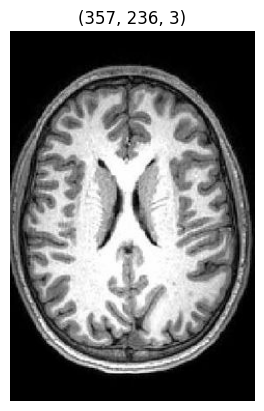

In [12]:
# View Random Image
view_random_image()

# Image Data Generator

In [13]:
IMG_SHAPE = (128,128)
BATCH_SIZE = 32

In [14]:
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split=0.5)
train_data = datagen.flow_from_directory(MAIN_DIR,
                                        target_size=IMG_SHAPE,
                                        batch_size=BATCH_SIZE,
                                        class_mode="binary",
                                        shuffle=True,
                                        subset="training")

test_data = datagen.flow_from_directory(MAIN_DIR,
                                       target_size=IMG_SHAPE,
                                       batch_size=BATCH_SIZE,
                                       class_mode="binary",
                                       shuffle=True,
                                       subset="validation")

Found 14474 images belonging to 2 classes.
Found 14474 images belonging to 2 classes.


In [15]:
print(f"Training samples: {len(train_data)}, Validation samples: {len(test_data)}")


Training samples: 453, Validation samples: 453


# Convolutional Neural Network

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [17]:
tf.random.set_seed(SEED)

model = Sequential([
    Conv2D(filters=64,
           kernel_size=3,
           activation='relu'),
    Conv2D(32,3,activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(32,3,activation='relu'),
    Conv2D(16,3,activation='relu'),
    MaxPool2D(2, padding='same'),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(),
              metrics=["accuracy"])

steps_per_epoch = train_data.samples // train_data.batch_size
validation_steps = test_data.samples // test_data.batch_size

# Fit the model
history = model.fit(train_data,
                    epochs=10,
                    #steps_per_epoch=steps_per_epoch,  # Use calculated steps_per_epoch
                    steps_per_epoch=8,
                    validation_data=test_data,
                    #validation_steps=validation_steps) # Use calculated validation_steps
                    validation_steps=10)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step - accuracy: 0.8219 - loss: 0.6368 - val_accuracy: 0.8469 - val_loss: 0.5675
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7909 - loss: 0.6058 - val_accuracy: 0.8188 - val_loss: 0.5597
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.7808 - loss: 0.5598 - val_accuracy: 0.8625 - val_loss: 0.4489
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7946 - loss: 0.5388 - val_accuracy: 0.7812 - val_loss: 0.5470
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.8022 - loss: 0.4922 - val_accuracy: 0.8344 - val_loss: 0.4476
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.8529 - loss: 0.4126 - val_accuracy: 0.8625 - val_loss: 0.5019
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8775 - loss: 0.4450 - val_accuracy: 0.8594 - val_loss: 0.3634
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.8467 - loss: 0.3737 - val_accuracy: 0.8625 - val_loss: 0

# Evaluation

In [18]:
# Function to plot loss curves
def plot_curves(history):

    """
    Returns separate loss and accuracy curves
    """
    import matplotlib.pyplot as plt

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

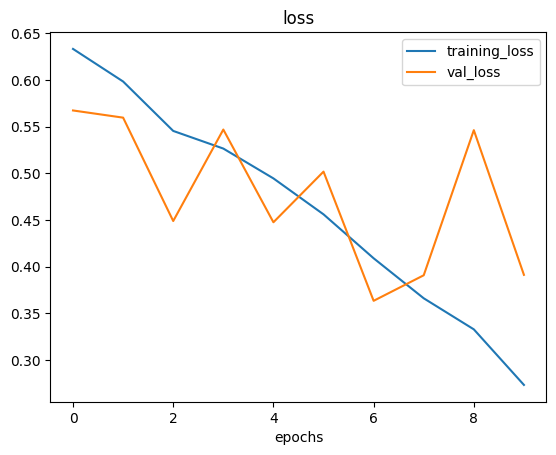

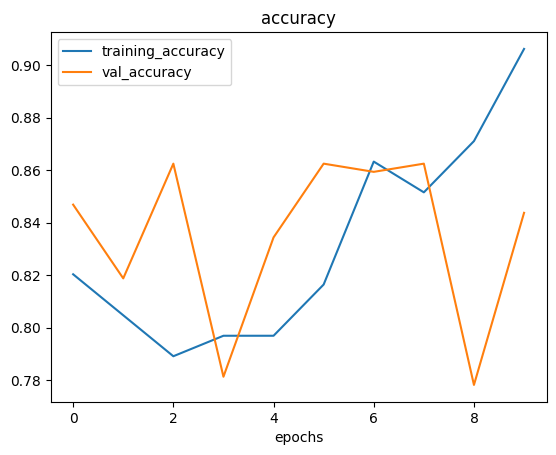

In [19]:
plot_curves(history)

In [20]:
result = model.evaluate(test_data, verbose=2)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

453/453 - 15s - 32ms/step - accuracy: 0.8443 - loss: 0.3925
Accuracy on Evaluation: 84.43%
Loss: 0.3925


## Transfer Learning with VGG16

The CNN model fails to perform well when train test split is introduced. Therefore, transfer learning has been introduced which gives us great results. It is trained with half the dataset, but still manages to produce great numbers.

###Transfer Learning:
Transfer learning is a technique in machine learning where a model that has been trained on one task is reused or adapted for a different but related task. Here’s a simple explanation:


*  **Learning from Experience:** Imagine you learn to ride a bicycle. Once you know how to balance and pedal on one type of bike, it’s much easier to ride a different type of bike, like a mountain bike or a racing bike. You’re not starting from scratch; you’re using what you already learned.

*  **Applying Knowledge:** In the same way, transfer learning allows a computer program (or model) that has learned to recognize certain patterns in a large dataset (like identifying everyday objects in photos) to apply that knowledge to a new, different task (like recognizing diseases in medical images).

*  **Saving Time and Resources:**Training a machine learning model from the ground up can take a lot of time, data, and computing power. With transfer learning, we can take an existing model that has already learned useful features and fine-tune it for our specific needs. This process is often faster and requires less data.

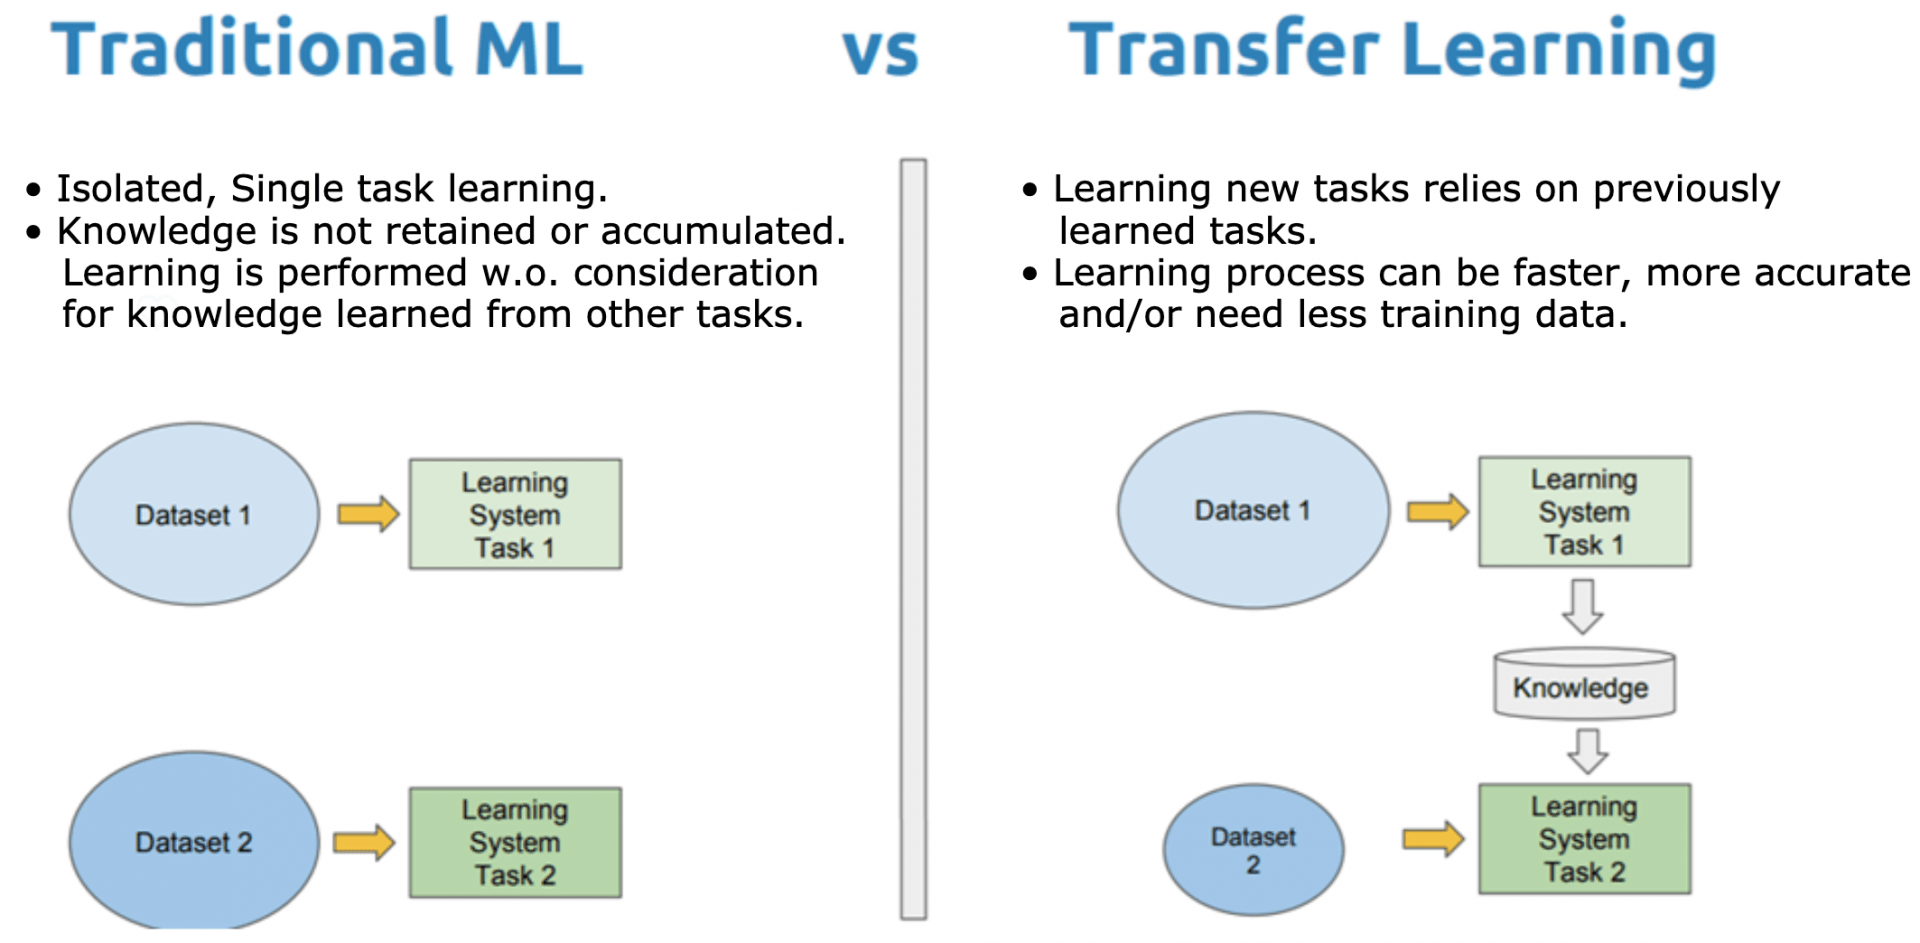

In [21]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setup
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
SEED = 40
MAIN_DIR = "/content/Brain Tumor Dataset(for binary classification)"  # Change this to your dataset path
IMG_SHAPE = (128, 128)
BATCH_SIZE = 32

# Data Generator
datagen = ImageDataGenerator(rescale=1/255., validation_split=0.5)

train_data = datagen.flow_from_directory(MAIN_DIR,
                                         target_size=IMG_SHAPE,
                                         batch_size=BATCH_SIZE,
                                         class_mode="binary",
                                         shuffle=True,
                                         subset="training",
                                         seed=SEED)

test_data = datagen.flow_from_directory(MAIN_DIR,
                                        target_size=IMG_SHAPE,
                                        batch_size=BATCH_SIZE,
                                        class_mode="binary",
                                        shuffle=True,
                                        subset="validation",
                                        seed=SEED)

# Load VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(),
              metrics=["accuracy"])

# Train the model
steps_per_epoch = train_data.samples // train_data.batch_size
validation_steps = test_data.samples // test_data.batch_size

history = model.fit(train_data,
                    epochs=10,
                    #steps_per_epoch=steps_per_epoch,
                    steps_per_epoch=8,
                    validation_data=test_data,
                    #validation_steps=validation_steps,
                    validation_steps=10)

Found 14474 images belonging to 2 classes.
Found 14474 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 259ms/step - accuracy: 0.8046 - loss: 0.7043 - val_accuracy: 0.8094 - val_loss: 0.8153
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.9158 - loss: 0.2648 - val_accuracy: 0.8781 - val_loss: 0.3296
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8676 - loss: 0.4311 - val_accuracy: 0.8313 - val_loss: 0.3377
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9210 - loss: 0.2081 - val_accuracy: 0.8719 - val_loss: 0.2934
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9345 - loss: 0.1896 - val_accuracy: 0.8813 - val_loss: 0.2566
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.9620 - loss: 0.1249 - val_accuracy: 0.8906 - val_loss: 0.2734
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9282 - loss: 0.1843 - val_accuracy: 0.8813

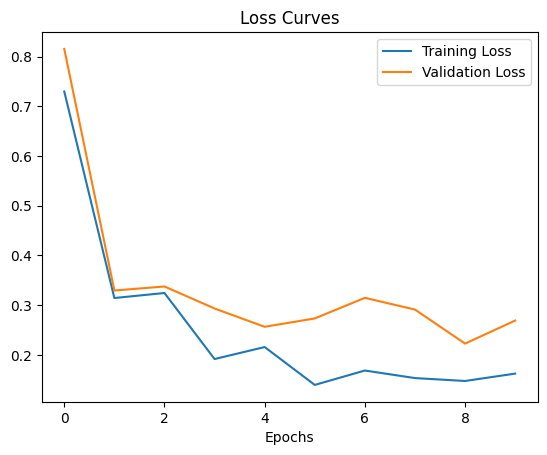

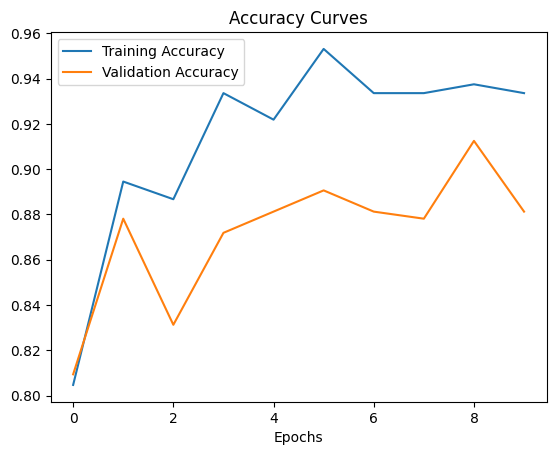

In [22]:
# Function to plot loss and accuracy curves
def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title("Loss Curves")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label="Training Accuracy")
    plt.plot(epochs, val_accuracy, label="Validation Accuracy")
    plt.title("Accuracy Curves")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

# Plot curves
plot_curves(history)

In [23]:
# Evaluate the model
result = model.evaluate(test_data, verbose=2)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

453/453 - 26s - 58ms/step - accuracy: 0.8937 - loss: 0.2557
Accuracy on Evaluation: 89.37%
Loss: 0.2557


# Explanation of VGG16 and Its Impact on Model Performance
## **Why We Used VGG16**: In the context of image classification tasks, such as detecting brain tumors from MRI scans, the choice of model architecture is critical for achieving high accuracy. VGG16, a convolutional neural network (CNN) architecture, is renowned for its effectiveness in visual recognition tasks. Here are some reasons why we chose VGG16 for our transfer learning approach:

**Pre-trained Weights**: VGG16 is pre-trained on the ImageNet dataset, which contains millions of labeled images across thousands of classes. This extensive training allows the model to learn rich feature representations that are transferable to other image classification tasks, like our brain tumor detection problem.

Deep Architecture: VGG16 consists of 16 layers (13 convolutional layers and 3 fully connected layers) that can learn increasingly abstract features from the input images. The deep architecture enables it to capture complex patterns in the data, which is crucial for tasks involving medical images.

Simplicity and Effectiveness: The VGG architecture is characterized by its simplicity, using small (3x3) convolutional filters and max pooling layers. This design helps to reduce the number of parameters while maintaining high performance, making it easier to train and less prone to overfitting.

# *How VGG16 Works*
VGG16 is built on a series of convolutional layers followed by max pooling layers. Here’s a high-level overview of how it operates:

**Convolutional Layers**: These layers apply filters to the input images to extract features. In VGG16, multiple convolutional layers are stacked, which allows the model to learn both low-level features (like edges and textures) and high-level features (like shapes and patterns).

**Max Pooling Layers**: After each set of convolutional layers, max pooling layers downsample the feature maps. This reduces the spatial dimensions, which helps decrease computational complexity and allows the model to become invariant to small translations in the input.

**Fully Connected Layers**: After several convolutional and pooling layers, the output feature maps are flattened and passed through fully connected layers. These layers perform high-level reasoning and classification based on the learned features. In the case of binary classification (such as detecting the presence or absence of a tumor), the final layer uses a sigmoid activation function.

**Transfer Learning**: By using the pre-trained weights of VGG16, we initialize our model with a strong set of learned features. This helps our model converge faster during training and often results in better performance compared to training a CNN from scratch, especially when the dataset is relatively small.

###***How VGG16 Helped Improve Our Accuracy***

Better Feature Extraction: The pre-trained VGG16 model provides a robust feature extractor that leverages its extensive training on diverse images. This allows it to generalize well to the specific features of MRI scans, significantly improving classification accuracy.

Reduced Training Time: By starting with a model that has already learned useful representations, we reduce the time and computational resources required to train our model on a smaller dataset, which helps prevent overfitting.

Higher Performance on Small Datasets: Transfer learning is particularly beneficial when the available dataset is limited, as is often the case in medical imaging. VGG16's ability to leverage learned features from a large dataset helps compensate for the lack of sufficient training data.

Fine-tuning Potential: After training with the frozen layers, we can further fine-tune some of the VGG16 layers by unfreezing them and training with a lower learning rate. This process helps adapt the model more specifically to our dataset, further improving accuracy.

#Conclusion
In summary, the implementation of VGG16 for transfer learning in our brain tumor detection task has provided significant advantages. Its pre-trained architecture, coupled with its ability to learn rich feature representations, has allowed us to achieve higher accuracy while training on a limited dataset. This approach not only enhances model performance but also highlights the power of transfer learning in advancing the field of medical image classification. By leveraging established models like VGG16, we can accelerate progress in developing reliable and accurate diagnostic tools in healthcare.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
0.9982741


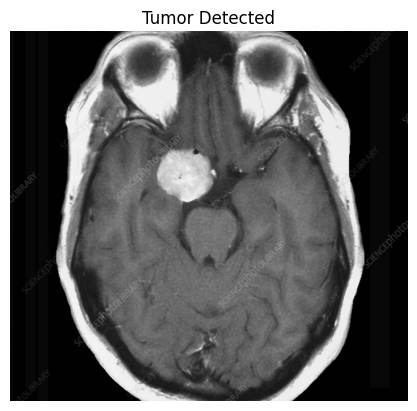

Prediction: Tumor Detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.21234131


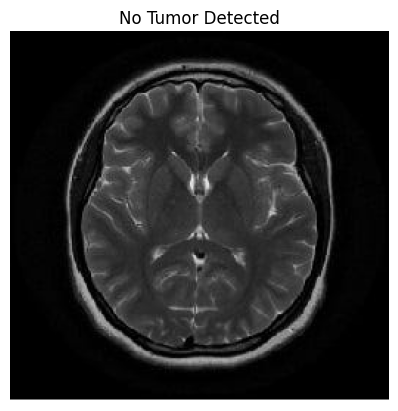

Prediction: No Tumor Detected


In [28]:
# Prediction Function
def predict_image(model, image_path):
    """
    Predicts if there is a tumor in the MRI image.

    Args:
        model: Trained model.
        image_path (str): Path to the MRI image.

    Returns:
        str: Prediction result - 'Tumor Detected' or 'No Tumor Detected'.
    """
    # Load and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        print("Error loading image.")
        return None

    img = cv2.resize(img, IMG_SHAPE)  # Resize to model's expected input shape
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = img / 255.0  # Rescale pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img)

    print(prediction[0][0])

    # Interpret result
    if prediction[0][0] >= 0.5:
        result = "Tumor Detected"
    else:
        result = "No Tumor Detected"

    # Display the image and result
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(result)
    plt.show()

    return result

# Example usage
image_path = "/content/ache.jpg"
prediction = predict_image(model, image_path)
print(f"Prediction: {prediction}")


image_path = "/content/nei.jpg"
prediction = predict_image(model, image_path)
print(f"Prediction: {prediction}")